## TC 5033
### Word Embeddings

### Team members:

+ Emmanuel Francisco González Velázquez - A01364577
+ Oscar Israel Lerma Franco - A01380817
+ Jesús Mario Martínez Díaz - A01740049
+ Eduardo Selim Martínez Mayorga - A01795167
+ José Antonio Hernández Hernández - A01381334

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [72]:
#!pip install torchtext torchdata
#!pip install torch torchvision torchaudio
#!pip install torch==2.0.1+cu118 torchtext==0.15.2 -f https://download.pytorch.org/whl/torch_stable.html

In [73]:
# For CUDA 11.8
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# For CUDA 11.7
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117


In [74]:
#!pip install scipy==1.7.3

In [75]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

In [76]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [77]:
# Load the AG_NEWS dataset, which consists of training and test datasets
train_dataset, test_dataset = AG_NEWS()
#Convert both the training and test datasets to a map-style dataset format
# Map-style datasets allow random access to samples, which is useful for indexing and transformations.
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

## Tokenizer Setup

1. **Obtain the tokenizer**: This code uses basic English tokenization to process text data.

2. **Define a generator function**: The function `yield_tokens` iterates over the dataset and applies the tokenizer to each text sample.


In [78]:
# Obtain the tokenizer
# Create a tokenizer object using basic English tokenization
tokeniser = get_tokenizer('basic_english')

# Define a generator function to yield tokens from the dataset
# The function iterates over each item in the data and applies the tokenizer to the text
def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)


# Text Data Preparation 

Steps for setting up text data for model training.

## Steps

1. **Vocabulary Setup**: Create a vocabulary with a special token for unknown words.
2. **Tokenization**: Verify tokenization on a sample.
3. **Dataset Splitting**: Split data into training, validation, and test sets.
4. **Configuration**: Define labels, max sequence length, and batch size.
5. **Collate Function**: Prepare data by tokenizing, padding, and converting to tensors.
6. **Data Loaders**: Create loaders for batching and shuffling the data.

This prepares the text data for efficient training and evaluation.

In [79]:
# Build the vocabulary from the training dataset by iterating over tokenized text
# 'specials' parameter is set to include "<unk>" as a special token for unknown words
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])

# Set the default index for unknown tokens to the index of "<unk>"
# This ensures that any out-of-vocabulary words are mapped to "<unk>" in the vocabulary
vocab.set_default_index(vocab["<unk>"])


In [80]:
# Test tokenization by applying the tokenizer to a sample sentence
tokens = tokeniser('Welcome to TE3007')

# Print the list of tokens and their corresponding indices in the vocabulary
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [81]:
# Calculate the number of samples for training, using 90% of the training dataset
NUM_TRAIN = int(len(train_dataset) * 0.9)

# Calculate the number of samples for validation as the remaining 10% of the training dataset
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [82]:
# Split the training dataset into two subsets: training and validation
# The split sizes are specified by NUM_TRAIN and NUM_VAL, calculated previously
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [83]:
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 108000
Validation set size: 12000
Test set size: 7600


In [84]:
# Define the labels for the dataset classes
# These represent the categories: World, Sports, Business, and Science/Technology
labels = ["World", "Sports", "Business", "Sci/Tech"]

# Set the maximum number of tokens (max_tokens) to 50
# Text sequences will be padded or truncated to this length
max_tokens = 50

# Define the batch size for data loading
# Each batch will contain 256 samples
BATCH_SIZE = 256

In [85]:
def collate_batch(batch):
    # Separate labels (y) and text (x) from the batch by unpacking
    y, x = list(zip(*batch))

    # Tokenize each text sample in the batch and convert to indices using the vocabulary
    x = [vocab(tokeniser(text)) for text in x]

    # Pad each tokenized text to a fixed length (max_tokens) or truncate if it exceeds max_tokens
    x = [t + ([0] * (max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Convert the processed text and adjusted labels to tensors, making sure y is of type Long
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.long) - 1



In [86]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

# Model Setup and Training

An overview of key steps to configure and train a text classification model.

## Steps

1. **Set Parameters**: Define embedding size, number of neurons, layers, and output classes.
2. **Define Model**: Create an RNN model with an embedding layer, an LSTM layer, and an output layer for classification.
3. **Accuracy Function**: Write a function to calculate model accuracy on any dataset.
4. **Training Function**: Define a function to train the model over multiple epochs, track loss, and update weights.
5. **Configure Training**: Set number of epochs and learning rate.
6. **Instantiate and Train**: Create the model, set up the optimizer, and start training.


In [87]:
# Set the embedding size for the input layer
# EMBEDDING_SIZE defines the dimensionality of the word embeddings for each token
EMBEDDING_SIZE = 100

# Define the number of neurons for each layer in the neural network
# NEURONS determines the size of the hidden layer(s) in the model
NEURONS = 128

# Specify the number of layers in the model
# LAYERS represents the number of hidden layers in the network
LAYERS = 2

# Set the number of output classes for the model
# NUM_CLASSES corresponds to the number of categories in the classification task (e.g., 4 for "World," "Sports," "Business," "Sci/Tech")
NUM_CLASSES = 4

In [88]:
# Define the RNN-based model class
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        # Initialize the superclass (nn.Module)
        super().__init__()

        # Define the embedding layer
        # Converts token indices into dense vectors of dimension 'embed_size'
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        # Define the recurrent layer (LSTM in this case, could also be RNN or GRU)
        # LSTM layer processes the sequence with 'embed_size' inputs and outputs 'hidden' features per time step
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden,
                           num_layers=layers,
                           batch_first=True)  # batch_first=True makes batch size the first dimension

        # Define a fully connected layer for classification
        # Maps the hidden state output to the number of classes
        self.fc = nn.Linear(hidden, num_classes)

    def forward(self, x):
        # x is a tensor of shape (batch_size, seq_length)

        # Apply the embedding layer to convert indices to dense vectors
        x = self.embedding_layer(x)  # Output shape: (batch_size, seq_length, embed_size)

        # Apply the RNN layer to process the embedded sequence
        # 'out' contains the output features for each time step, '_ ' contains hidden and cell states
        out, _ = self.rnn(x)  # Output shape: (batch_size, seq_length, hidden)

        # Select the output from the last time step for classification purposes
        out = out[:, -1, :]  # Shape: (batch_size, hidden)

        # Pass through the fully connected layer to produce the final output
        out = self.fc(out)  # Shape: (batch_size, num_classes)

        return out


In [89]:
# Define a function to calculate the accuracy of the model on a given data loader
def accuracy(model, loader):
    model.eval()  # Set the model to evaluation mode to disable dropout/batch norm layers
    correct = 0   # Counter for correct predictions
    total = 0     # Counter for total samples

    with torch.no_grad():  # Disable gradient calculation for faster evaluation
        for x, y in loader:
            # Move data to the specified device (e.g., GPU if available)
            x, y = x.to(device), y.to(device)

            # Perform a forward pass through the model to get predictions
            outputs = model(x)

            # Find the predicted class by taking the index of the maximum logit along dimension 1
            _, predicted = torch.max(outputs, 1)

            # Update correct predictions count by comparing predicted and true labels
            correct += (predicted == y).sum().item()

            # Update the total count with the batch size
            total += y.size(0)

    # Calculate accuracy as a percentage
    accuracy = 100 * correct / total
    return accuracy  # Return the calculated accuracy


In [90]:
# Define the training function for the model
def train(model, optimiser, train_loader, val_loader, criterion, epochs=100):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode to enable dropout/batch norm layers
        running_loss = 0.0  # Accumulate loss for averaging over each epoch

        # Iterate over each batch in the training loader
        for x, y in train_loader:
            # Move data to the specified device (e.g., GPU if available)
            x, y = x.to(device), y.to(device)

            # Zero the gradients to prevent accumulation from previous steps
            optimiser.zero_grad()

            # Forward pass: compute predictions
            outputs = model(x)
            loss = criterion(outputs, y)  # Compute loss between predictions and true labels

            # Backward pass: compute gradients of loss with respect to model parameters
            loss.backward()
            optimiser.step()  # Update model parameters based on gradients

            # Accumulate loss for the epoch, adjusting by batch size
            running_loss += loss.item() * x.size(0)

        # Calculate the average loss for the epoch by dividing by total training samples
        epoch_loss = running_loss / len(train_loader.dataset)

        # Evaluate the model's accuracy on training and validation sets
        train_acc = accuracy(model, train_loader)
        val_acc = accuracy(model, val_loader)

        # Print epoch details: epoch number, loss, and accuracies for training and validation sets
        print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {epoch_loss:.4f} - Training Accuracy: {train_acc:.2f}% - Validation Accuracy: {val_acc:.2f}%")


In [91]:
# Define training parameters
epochs = 10  # Number of epochs for training; increase if more training is needed
lr = 0.001   # Learning rate for the optimizer, controls the step size during weight updates

# Instantiate the model with specified embedding size, neurons, layers, and number of classes
# Move the model to the specified device (e.g., GPU if available)
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES).to(device)

# Set up the optimizer with model parameters and defined learning rate
# Adam optimizer is used for its adaptive learning rate and efficiency in handling sparse gradients
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [92]:
# Train the model using the specified training function
# Pass the following arguments:
# - rnn_model: the neural network model to train
# - optimiser: the optimizer used to update the model's weights
# - train_loader: DataLoader for the training dataset
# - val_loader: DataLoader for the validation dataset
# - criterion: the loss function, in this case, CrossEntropyLoss for multi-class classification
# - epochs: the number of training epochs to run
train(rnn_model, optimiser, train_loader, val_loader, criterion=nn.CrossEntropyLoss(), epochs=epochs)

Epoch [1/10] - Loss: 0.7764 - Training Accuracy: 85.25% - Validation Accuracy: 84.40%
Epoch [2/10] - Loss: 0.3585 - Training Accuracy: 91.12% - Validation Accuracy: 88.85%
Epoch [3/10] - Loss: 0.2651 - Training Accuracy: 92.51% - Validation Accuracy: 89.50%
Epoch [4/10] - Loss: 0.2158 - Training Accuracy: 93.95% - Validation Accuracy: 89.85%
Epoch [5/10] - Loss: 0.1759 - Training Accuracy: 95.56% - Validation Accuracy: 90.51%
Epoch [6/10] - Loss: 0.1450 - Training Accuracy: 96.56% - Validation Accuracy: 90.78%
Epoch [7/10] - Loss: 0.1200 - Training Accuracy: 97.20% - Validation Accuracy: 90.69%
Epoch [8/10] - Loss: 0.0993 - Training Accuracy: 97.79% - Validation Accuracy: 90.62%
Epoch [9/10] - Loss: 0.0813 - Training Accuracy: 97.62% - Validation Accuracy: 90.33%
Epoch [10/10] - Loss: 0.0681 - Training Accuracy: 98.58% - Validation Accuracy: 90.43%


# Model Evaluation and Prediction

This section covers steps for evaluating the trained model, making predictions, and visualizing results.

## Steps

1. **Test Set Accuracy**: Print the model’s accuracy on the test dataset for a quick performance check.

2. **Text Prediction**: Define a function to predict the label of a new text sample. This function:
   - Tokenizes and encodes the input text.
   - Pads or truncates it to the maximum length.
   - Passes it through the model in evaluation mode to return a predicted label.

3. **Sample Prediction**: Test the prediction function with a sample text from the dataset and print the result.

4. **Confusion Matrix Plotting**: Define a function to create a confusion matrix, which provides a detailed view of the model’s classification performance.
   - The function calculates predictions on the test set.
   - Uses a heatmap to visualize how well the model differentiates between each class.

5. **Display Confusion Matrix**: Call the function to plot and display the confusion matrix for the test dataset.

This setup provides insights into model accuracy, prediction capabilities, and classification performance across different categories.


In [94]:
# Print the accuracy of the trained model on the test dataset
# - accuracy(rnn_model, test_loader): calculates the model's accuracy on the test data
# - :.4f formats the accuracy to four decimal places for readability
print(f'{accuracy(rnn_model, test_loader):.4f}'

90.5395


In [95]:
# Function to predict the label of a given text sample using the trained model
def sample_text(model, text):
    model.eval()  # Set the model to evaluation mode to disable dropout/batch norm layers

    # Tokenize and encode the input text using the tokenizer and vocabulary
    tokens = tokeniser(text)
    token_ids = vocab(tokens)

    # Pad or truncate the tokenized text to the maximum length (max_tokens)
    token_ids = token_ids[:max_tokens] + [0] * (max_tokens - len(token_ids))

    # Convert the list of token IDs to a tensor and move it to the specified device
    input_tensor = torch.tensor([token_ids], dtype=torch.int32).to(device)

    with torch.no_grad():  # Disable gradient calculations for inference
        # Perform a forward pass through the model to get predictions
        output = model(input_tensor)
        # Get the predicted class by finding the index with the highest score
        _, predicted_class = torch.max(output, 1)

    # Map the predicted class index to the corresponding label
    predicted_label = labels[predicted_class.item()]
    return predicted_label  # Return the predicted label for the input text


In [96]:

# Create an iterator over the AG_NEWS training dataset
train_iter = iter(AG_NEWS(split='train'))

# Get the next item from the iterator, which returns a label and a sample text
label, sampleTxt = next(train_iter)

# Print the sample text and the predicted label using the sample_text function
# sample_text(rnn_model, sampleTxt) predicts the label for the given sample text
print("Sample text:\n", sampleTxt, "\nPredicted Label:", sample_text(rnn_model, sampleTxt))


Sample text:
 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again. 
Predicted Label: Business


In [101]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to plot the confusion matrix for a given model and dataset
def plot_confusion_matrix(model, loader, labels):
    model.eval()  # Set model to evaluation mode to disable dropout/batch norm layers
    all_preds = []  # List to store all predicted labels
    all_labels = []  # List to store all true labels

    with torch.no_grad():  # Disable gradient calculations for efficiency
        for x, y in loader:
            # Move data to the specified device (e.g., GPU if available)
            x, y = x.to(device), y.to(device)

            # Get model predictions
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class index

            # Store the predictions and actual labels as numpy arrays (on CPU)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute the confusion matrix using true and predicted labels
    cm = confusion_matrix(all_labels, all_preds)

    # Plot the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(8, 6))  # Set the figure size
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")  # Label the x-axis
    plt.ylabel("True Label")       # Label the y-axis
    plt.title("Confusion Matrix")  # Set the plot title
    plt.show()  # Display the plot


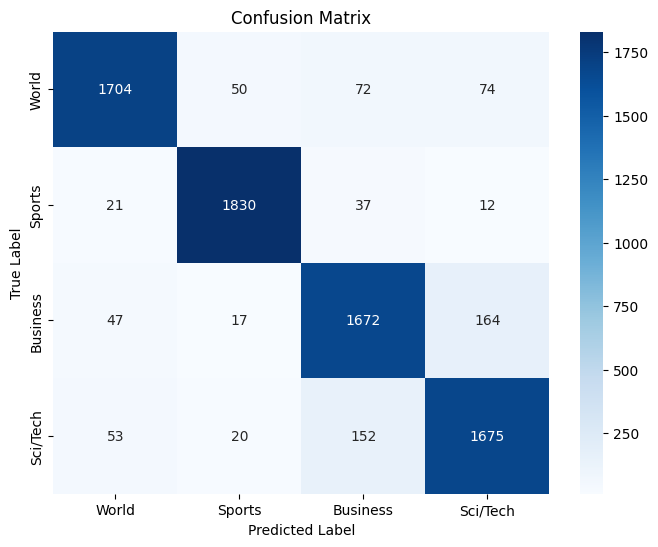

In [103]:
# Call the plot_confusion_matrix function to visualize the confusion matrix
# Arguments:
# - rnn_model: the trained model to evaluate
# - test_loader: DataLoader for the test dataset
# - labels: list of class labels to display on the matrix axes
plot_confusion_matrix(rnn_model, test_loader, labels=["World", "Sports", "Business", "Sci/Tech"])
